# Описание задачи

Вы получили основные навыки обработки данных, теперь пора испытать их на практике. Сейчас вам предстоит заняться задачей классификации.

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.

Вспомните о всем, что я говорил на предыдущих занятиях. Не все будет пригодится, но в жизни вам никто не будет говорить, что использовать :)

Хорошим классификатором для этой задачи будет "Случайный лес" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Понимать суть работы "леса" не обязательно на данном этапе, но качество предсказаний будет выше, чем с линейным классификатором. (если желаете, вот гайд https://adataanalyst.com/scikit-learn/linear-classification-method/)

Желаю успеха :)

# Импорты и загрузка данных

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import pandas_profiling

from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('aac_shelter_outcomes.csv')
data.head(5)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


# Проверка наличия/обработка пропусков, удаление и создание признаков

In [3]:
data.shape

(78256, 12)

In [4]:
data.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,78248,78256,78256,78256,78256,78256,78256,78256,54370,35963,78244,78254
unique,46,70855,5,2128,525,5869,64361,64361,14574,19,9,5
top,1 year,A718223,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14355,11,44242,23335,8153,112,39,39,344,19660,33112,27784


Пропуски в переменных age_upon_outcome - 7 шт. (возраст во время передачи из приюта). Предположительно, можно заполнить разностью между datetime и date_of_birth.
Пропуски в name - около 30%. Заполнять нет смысла, убирать строки нельзя. Вероятно, признак в целом лишний.
Пропуски в outcome_subtype - 54%. Покскольку это подтип нашего таргета, то в новых данных, которые нам предстоит класиифицировать не будет этой переменной. С учетом её низкого качества - удаляем переменную.
Пропуски в outcome_type - 0.01% - удалим строки с пропусками.

In [5]:
# data[data['outcome_type'].fillna(-1) == -1] #Пропуски в outcome_type - 0.01% - удалим строки с пропусками.
data = data[data['outcome_type'].fillna(-1) != -1]

In [6]:
# преобразуем строковые данные в даты
def get_date(str):
    return datetime.datetime.strptime(str,"%Y-%m-%dT%H:%M:%S")

data['date_of_birth_new'] = data['date_of_birth'].apply(get_date)
data['datetime_new'] = data['datetime'].apply(get_date)
data['monthyear_new'] = data['monthyear'].apply(get_date)

In [7]:
data.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,date_of_birth_new,datetime_new,monthyear_new
count,78238,78244,78244,78244,78244,78244,78244,78244,54363,35963,78244,78243,78244,78244,78244
unique,46,70848,5,2128,525,5869,64352,64352,14574,19,9,5,5869,64352,64352
top,1 year,A718223,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male,2014-05-05 00:00:00,2016-04-18 00:00:00,2016-04-18 00:00:00
freq,14352,11,44238,23332,8151,112,39,39,344,19660,33112,27783,112,39,39
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991-12-11 00:00:00,2013-10-01 09:31:00,2013-10-01 09:31:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-25 00:00:00,2018-02-01 18:44:00,2018-02-01 18:44:00


In [8]:
# Предположительно, datetime и monthyear - дубли. Проверим:
data["timedelta"] = abs(data['datetime_new']-data['monthyear_new'])
data["timedelta"].sum()

Timedelta('0 days 00:00:00')

In [9]:
# Подтверждено. Удаляем лишние переменные
data = data.drop(columns = ['datetime','monthyear','monthyear_new','timedelta'])

In [10]:
data.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,name,outcome_subtype,outcome_type,sex_upon_outcome,date_of_birth_new,datetime_new
count,78238,78244,78244,78244,78244,78244,54363,35963,78244,78243,78244,78244
unique,46,70848,5,2128,525,5869,14574,19,9,5,5869,64352
top,1 year,A718223,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,Bella,Partner,Adoption,Neutered Male,2014-05-05 00:00:00,2016-04-18 00:00:00
freq,14352,11,44238,23332,8151,112,344,19660,33112,27783,112,39
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1991-12-11 00:00:00,2013-10-01 09:31:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-25 00:00:00,2018-02-01 18:44:00


In [11]:
# В sex_upon_outcome есть 1 пропуск
data[data['sex_upon_outcome'].fillna(-1) == -1]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,name,outcome_subtype,outcome_type,sex_upon_outcome,date_of_birth_new,datetime_new
16300,7 years,A667395,Dog,Dachshund,Brown Merle,2006-11-17T00:00:00,Diego,NaN,Return to Owner,NaN,2006-11-17,2013-11-27 16:11:00


In [12]:
# Пса зовут Диего, пожелаем ему удачи, вернем пол "Intact Male"
data.set_value(16300,'sex_upon_outcome','Intact Male')
data.loc[16300]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


age_upon_outcome                 7 years
animal_id                        A667395
animal_type                          Dog
breed                          Dachshund
color                        Brown Merle
date_of_birth        2006-11-17T00:00:00
name                               Diego
outcome_subtype                      NaN
outcome_type             Return to Owner
sex_upon_outcome             Intact Male
date_of_birth_new    2006-11-17 00:00:00
datetime_new         2013-11-27 16:11:00
Name: 16300, dtype: object

In [13]:
# Предположение: признак age_upon_outcome - округленная разница между date_of_birth и datetime. Проверим
data["age_upon_outcome_new"] = data['datetime_new']-data['date_of_birth_new']
data["age_upon_outcome_new"] = data["age_upon_outcome_new"].apply(lambda x: x.days)

In [14]:
def get_age(str):
    y=0
    try:
        x = int(str.split(' ')[0])
        p = str.split(' ')[1]
    except:
        x=0
        p=''       
    if p[0:4]=='year':
        y=365
    elif p[0:5]=='month':
        y=30
    elif p[0:4]=='week':
        y=7
    elif p[0:3]=='day':
        y=1 
    else:
        p=0
    return x*y

data["age_check"] = data['age_upon_outcome'].apply(get_age)
data[["age_upon_outcome_new","age_check"]].corr()

,age_upon_outcome_new,age_check
age_upon_outcome_new,1.000000,0.997795
age_check,0.997795,1.000000


In [15]:
# Корреляция почти равна 1. Таким образрм, в данных только 1 полезный признак (среди переменных даты-времени) - возраст животного. Удаляем лишние признак вместе с временным. А также name и outcome_subtype
data = data.drop(columns = ['age_upon_outcome','age_check','name','outcome_subtype','datetime_new','date_of_birth_new','date_of_birth','animal_id'])

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78244 entries, 0 to 78255
Data columns (total 6 columns):
animal_type             78244 non-null object
breed                   78244 non-null object
color                   78244 non-null object
outcome_type            78244 non-null object
sex_upon_outcome        78244 non-null object
age_upon_outcome_new    78244 non-null int64
dtypes: int64(1), object(5)
memory usage: 6.7+ MB


In [17]:
# Выделим основный цвет животного
data['primary_color']=data['color'].apply(lambda x: x.split('/')[0].split(' ')[0])

In [18]:
# Выделим пол животного
data['sex'] = data['sex_upon_outcome'].apply(lambda x: x.split(' ')[::-1][0])

In [24]:
# Выделим способность к размножению
data['reproducing'] = data['sex_upon_outcome'].apply(lambda x: x.split(' ')[0])
def rep(str):
    if str == 'Intact':
        return 'yes'
    elif str == 'Unknown':
        return str
    else:
        return 'no'
data['reproducing'] = data['reproducing'].apply(rep)

In [34]:
# удалим дублирующие признаки
data = data.drop(columns=['color','sex_upon_outcome'])


# Взаимосвязи между признаками

In [33]:

data.profile_report()

Корреляция Крамера для категориальных переменных говорит о взаимосвязи outcome_type с reproducing и sex

In [97]:
data.head()

,animal_type,breed,outcome_type,age_upon_outcome_new,primary_color,sex,reproducing
0,Cat,Domestic Shorthair Mix,Transfer,15,Orange,Male,yes
1,Dog,Beagle Mix,Transfer,366,White,Female,no
2,Dog,Pit Bull,Adoption,429,Blue,Male,no
3,Dog,Miniature Schnauzer Mix,Transfer,3300,White,Male,no
4,Other,Bat Mix,Euthanasia,181,Brown,Unknown,Unknown


# RandomForest 1

In [106]:
cat_columns = ["animal_type", "sex", "reproducing","outcome_type"]

In [108]:
data_processed = pd.get_dummies(data, prefix_sep="__",
                              columns=cat_columns)

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder

In [128]:
output_ = data_processed.iloc[:,14:]

# input_cols = ["animal_type","breed","outcome_type","age_upon_outcome_new","primary_color","sex","reproducing"]
input_ = data_processed.iloc[:,:14]
input_ = input_.drop(columns = ['primary_color','breed'])


In [129]:
le=LabelEncoder()
targets=(output_.iloc[:,:]==1).idxmax(1)
Y=le.fit_transform(targets)

In [130]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_, Y, test_size=0.3)

No handles with labels found to put in legend.


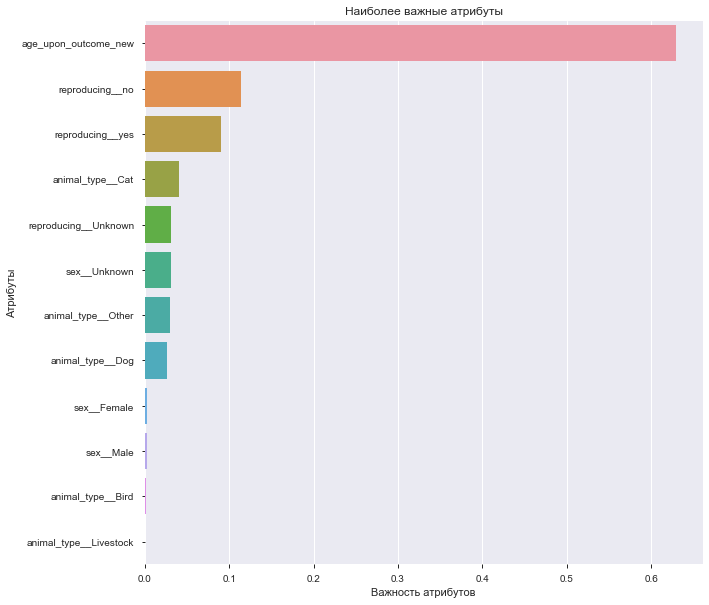

In [131]:
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)

# создаем модель деревья решений
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train,y_train)

headers = list(X_train.columns.values)
feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

In [132]:
model.score(X_test, y_test)

0.6684842804805317

# RandomForest2

Поробуем избавиться от лишних данных в таргете исходя из условия задачи

In [154]:
data_rf2 = data[data["outcome_type"].isin(['Transfer','Adoption'])]

In [155]:
cat_columns = ["animal_type", "sex", "reproducing","outcome_type"]
data_processed = pd.get_dummies(data_rf2, prefix_sep="__",
                              columns=cat_columns)

output_ = data_processed.iloc[:,14:]

input_ = data_processed.iloc[:,:14]
input_ = input_.drop(columns = ['primary_color','breed'])

In [158]:
le=LabelEncoder()
targets=(output_.iloc[:,:]==1).idxmax(1)
Y=le.fit_transform(targets)

In [159]:
X_train, X_test, y_train, y_test = train_test_split(input_, Y, test_size=0.3)

model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

model.score(X_test, y_test)

0.7996938294865756

# RandomForest3

Поробуем теперь преобразовать 'primary_color','breed' в вектора, после чего уменьшить размерность с помощью PCA

In [165]:
cat_columns = ["animal_type", "sex", "reproducing",'primary_color','breed',"outcome_type"]
data_processed = pd.get_dummies(data_rf2, prefix_sep="__",
                              columns=cat_columns)

output_ = data_processed.iloc[:,1845:]
input_ = data_processed.iloc[:,:1845]

In [174]:
le=LabelEncoder()
targets=(output_.iloc[:,:]==1).idxmax(1)
Y=le.fit_transform(targets)

In [182]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 50)
XPCAreduced = pca.fit_transform(np.transpose(input_.T))
input_reduced = pd.DataFrame(XPCAreduced)

In [183]:
X_train, X_test, y_train, y_test = train_test_split(input_reduced, Y, test_size=0.3)

model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

model.score(X_test, y_test)

0.7829722091380122

Любопытно, что при изменении размерности (n_components) точность модели не сильно меняется: от 0.7878 при 1, до 0.782 при 50. При этом время расчет изменяется кратно.
Вывод: в данном случае использование признаков 'primary_color','breed' не приносит дополнительной точности модели, поэтому лучше их убрать. Тогда и PCA не понадобиться, т.к. размерность небольшая.